# Reproducing Figure 3A-D

Figure 2 presents results from sensitivity analysis of configuration 1.

**Note:** These are created from 10 replications currently for simplicity. At 10 replications, we would expect mean values to vary only slightly from further replication numbers. Hence, if felt similar at 10, have marked as succesfully reproduced without also testing at 100 replications.

## Parameters

In these figures, we vary:

* **Number of inpatient/childbirth/ANC cases per day**:
    * 1 = IAT 1440 (e.g. like IPD cases for config1)
    * 2 = IAT 720 (as 2880 is 0.5 per day and 1440 is 1 per day)
* **Average service time for outpatients**:
    * 0.87 (0.21) (same as config1)
    * 2.5 (0.5) (as in figure 2)

## Set up

In [1]:
# To run model
import PHC

# To import results and produce figures
import xlrd
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# To speed up run time
from multiprocessing import Pool

'''
# Additional package to record runtime of this notebook
import time
start = time.time()
'''

'\n# Additional package to record runtime of this notebook\nimport time\nstart = time.time()\n'

In [2]:
# Paths to save image files to
output_folder = 'outputs'
fig3a_path = os.path.join(output_folder, 'fig3a.png')
fig3b_path = os.path.join(output_folder, 'fig3b.png')
fig3c_path = os.path.join(output_folder, 'fig3c.png')
fig3d_path = os.path.join(output_folder, 'fig3d.png')

## Run model

In [3]:
# TODO: Run with 100 replications

# Varying number of inpatient, childbirth and ANC cases
arr_dict = [
    {
        'IPD_iat': 1440,
        'delivery_iat': 1440,
        'ANC_iat': 1440,
        'rep_file': 'arr111'
    },
    {
        'IPD_iat': 720,
        'delivery_iat': 1440,
        'ANC_iat': 1440,
        'rep_file': 'arr211',
    },
    {
        'IPD_iat': 720,
        'delivery_iat': 720,
        'ANC_iat': 720,
        'rep_file': 'arr222',
    }
]

# Varying service time
serv_dict = [
    {
        'mean': 0.87,
        'sd': 0.21,
        'consult_boundary_1': 0.5,  # From PHC.py
        'consult_boundary_2': 0.3,  # From PHC.py
        'rep_file': 'serv087'
    },
    {
        'mean': 2.5,
        'sd': 0.5,
        'consult_boundary_1': 1,  # From Figure 2 (which was a guess)
        'consult_boundary_2': 1,  # From Figure 2 (which was a guess)
        'rep_file': 'serv25'
    }
]

Create each combination for the reproduction

In [4]:
dict_list = []
for arr in arr_dict:
    for serv in serv_dict:
        # Combine the dictionaries
        comb = {**arr, **serv}
        # Replace the file name
        comb['rep_file'] = f'''f3_{arr['rep_file']}_{serv['rep_file']}.xls'''
        # Save to list
        dict_list.append(comb)

len(dict_list)

6

In [5]:
# Append 's_' to all items
for i, d in enumerate(dict_list):
    dict_list[i] = {f's_{k}': v for k, v in d.items()}

# Preview example
dict_list[0]

{'s_IPD_iat': 1440,
 's_delivery_iat': 1440,
 's_ANC_iat': 1440,
 's_rep_file': 'f3_arr111_serv087.xls',
 's_mean': 0.87,
 's_sd': 0.21,
 's_consult_boundary_1': 0.5,
 's_consult_boundary_2': 0.3}

Run the model (with parallel processing to reduce run time)

In [6]:
'''
# Wrapper function to allow input of dictionary with pool
def wrapper(d):
    return PHC.main(**d)

# Create a process pool that uses all CPUs
with Pool() as pool:
    # Run PHC.main() using each of inputs from config
    pool.map(wrapper, dict_list)
'''

'\n# Wrapper function to allow input of dictionary with pool\ndef wrapper(d):\n    return PHC.main(**d)\n\n# Create a process pool that uses all CPUs\nwith Pool() as pool:\n    # Run PHC.main() using each of inputs from config\n    pool.map(wrapper, dict_list)\n'

## Process results

In [7]:
def process_results(files):
    '''
    Imports files in provided list and produces a single dataframe with mean
    results from across the replications

    Parameters:
    ----------
    files : list
        List of file names (exc. file type) containing replication results

    Returns:
    --------
    summary : dataframe
        Dataframe with mean results for each model variant in file list
    '''
    # Empty list to store results
    result_list = []

    for f in files:
        # Import .xls and convert to pandas dataframe
        book = xlrd.open_workbook(os.path.join(output_folder, f'{f}.xls'))
        result = pd.read_excel(book, header=None, index_col=0)

        # Find mean from the replication
        # Save as dataframe, dropping the duplicate rows (NCD occ twice)
        res = pd.DataFrame({f: result.mean(axis=1)}).drop_duplicates()

        # Remove index name
        res.index.name = None

        # Save to list
        result_list.append(res)

    # Combine into single dataframe
    summary = pd.concat(result_list, axis=1)

    return summary

## Create Figure 3A

In [8]:
# Import and process results
data_full = process_results([
    'f3_arr111_serv087', 'f3_arr211_serv087', 'f3_arr222_serv087',
    'f3_arr111_serv25', 'f3_arr211_serv25', 'f3_arr222_serv25'])

# Filter to doctor utilisation
a3 = data_full.loc['doc occ']
a3

f3_arr111_serv087    0.269199
f3_arr211_serv087    0.271072
f3_arr222_serv087    0.289770
f3_arr111_serv25     0.513668
f3_arr211_serv25     0.517088
f3_arr222_serv25     0.537383
Name: doc occ, dtype: float64

In [9]:
# Reshape data so in appropriate format for plotting grouped bar chart
names = ['0.87 (0.21)', '2.5 (0.5)']
s111 = [a3['f3_arr111_serv087'], a3['f3_arr111_serv25']]
s211 = [a3['f3_arr211_serv087'], a3['f3_arr211_serv25']]
s222 = [a3['f3_arr222_serv087'], a3['f3_arr222_serv25']]

data_3a = pd.DataFrame(
    {'(1/1/1)': s111, '(2/1/1)': s211, '(2/2/2)': s222}, index=names)
data_3a

,(1/1/1),(2/1/1),(2/2/2)
0.87 (0.21),0.269199,0.271072,0.289770
2.5 (0.5),0.513668,0.517088,0.537383


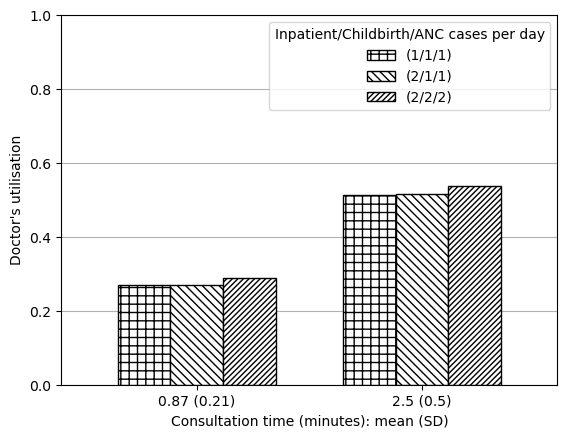

In [21]:
# Plot data
ax = data_3a.plot.bar(edgecolor='black', color='white', width=0.7)

# Add patterns
bars = ax.patches
pattern = np.repeat(['++', '\\\\\\\\', '//////'], 2)
for bar, hatch in zip(bars, pattern):
    bar.set_hatch(hatch)
ax.legend(title='Inpatient/Childbirth/ANC cases per day')

# Adjust figure
plt.xlabel('Consultation time (minutes): mean (SD)')
plt.ylabel('''Doctor's utilisation''')
plt.xticks(rotation=0)
ax.grid(axis='y')
plt.ylim(0, 1)
ax.set_axisbelow(True)
plt.savefig(fig3a_path, bbox_inches='tight')
plt.show()

## Run time

In [11]:
'''
# Find run time in seconds
end = time.time()
runtime = round(end-start)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime//60}m {runtime%60}s')
'''

"\n# Find run time in seconds\nend = time.time()\nruntime = round(end-start)\n\n# Display converted to minutes and seconds\nprint(f'Notebook run time: {runtime//60}m {runtime%60}s')\n"